In [1]:
from uproot_io import Events, View
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
#titlesize = 20
#labelsize = 14
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [30]:
x_train = np.load("x_train_cut.npy")
y_train = np.load("y_train_cut.npy")
x_test = np.load("x_test_cut.npy")
y_test = np.load("y_test_cut.npy")

In [31]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdt = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdt.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [32]:
# Check the training set classification performance
bdt.score(x_train, y_train)

1.0

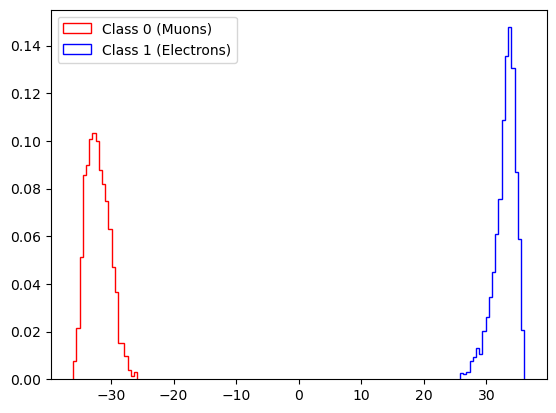

In [33]:
f0 = bdt.decision_function(x_train)
min_f = np.round(np.min(f0), 1)
max_f = np.round(np.max(f0), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f0 = f0[np.where(y_train == 0)]
cls_1_f0 = f0[np.where(y_train == 1)]
weights_0 = np.ones_like(cls_0_f0) / len(cls_0_f0)
weights_1 = np.ones_like(cls_1_f0) / len(cls_1_f0)
plt.hist(cls_0_f0, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Muons)')
plt.hist(cls_1_f0, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Electrons)')
plt.legend()

In [34]:
# Check the test set classification performance
bdt.score(x_test, y_test)

0.9454036397573495

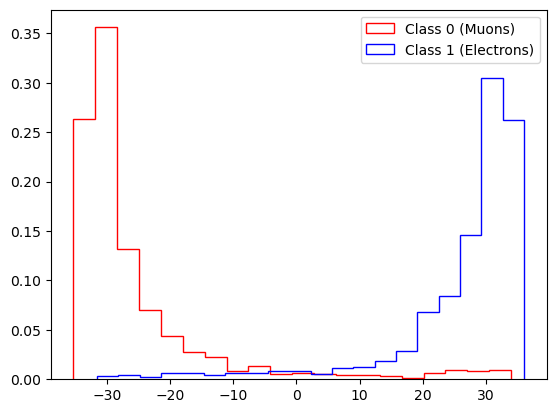

In [35]:
f = bdt.decision_function(x_test)
min_f = np.round(np.min(f), 1)
max_f = np.round(np.max(f), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = f[np.where(y_test == 0)]
cls_1_f = f[np.where(y_test == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Muons)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Electrons)')
plt.legend()

In [36]:
print(min(cls_0_f)), print(max(cls_1_f))

-35.29104452070886
36.04365338911712


(None, None)

In [37]:
TIT = cls_1_f
SIT = cls_0_f

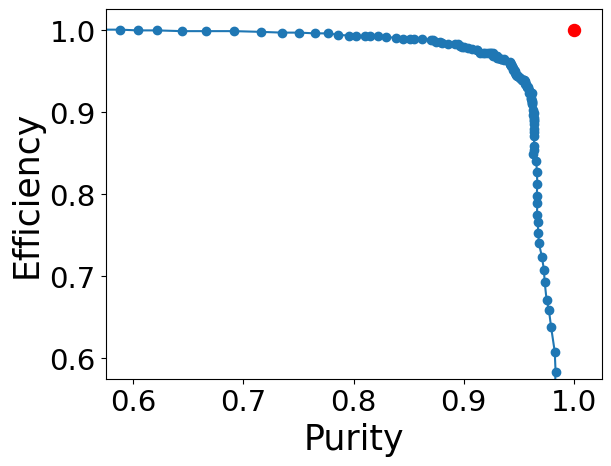

Best cut: -4.5
At distance: 0.07050279612480902
With AUC: 0.9766604218041292


In [38]:
cuts = np.arange(-35, 35, 0.5)
efficiency = []
purity = []

purity.append(0)
efficiency.append(1)

for i in cuts:
    goodtrk = []
    badtrk = []
    goodshw = []
    badshw = []
    for n in TIT:
        if n >= i:
            goodtrk.append(n)
        else:
            badtrk.append(n)
    for k in SIT:
        if k >= i:
            badshw.append(k)
        else:
            goodshw.append(k)

    eff = len(goodtrk)/(len(TIT))
    pur = len(goodtrk)/(len(goodtrk)+len(badshw))

    efficiency.append(eff)
    purity.append(pur)

purity.append(1)
efficiency.append(0)

plt.scatter(purity, efficiency)
plt.plot(purity, efficiency)
plt.scatter(1, 1, s=75, c='r')
plt.xlim(0.6,1.025)
#plt.ylim(0.6,1.025)
plt.xlabel('Purity', fontsize=25)
plt.ylabel('Efficiency', fontsize=25)
#plt.title('ROC Curve for Track Likelihood')
plt.xticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.yticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.xlim(0.575,1.025)
plt.ylim(0.575,1.025)
plt.show()

np.save("CE_BDT", efficiency)
np.save("CP_BDT", purity)

area = np.trapz(efficiency, x=purity)

point = np.array([1, 1])
data_points = np.column_stack((purity, efficiency))
distances = np.linalg.norm(data_points - point, axis=1)
closest_index = np.argmin(distances)
closest_point = data_points[closest_index]
dist = distances[closest_index]
cutpoint = cuts[closest_index]

print('Best cut:', cutpoint)
print('At distance:', dist)
print('With AUC:', area)

#efficiency (true tracks as tracks/total true tracks)
#purity (true tracks as tracks/number we have called tracks)

In [39]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")
truth = np.load("truth_data.npy")

In [40]:
#SHOWERS = MUONS, TRACKS = ELECTRONS NOW


In [41]:
TTAT = []
TTAS = []
TSAT = []
TSAS = []

for i, n in enumerate(TIT):
    if n >= cutpoint:
        TTAT.append(n)
    if n < cutpoint:
        TTAS.append(n)
        
for i, k in enumerate(SIT):
    if k >= cutpoint:
        TSAT.append(k)
    if k < cutpoint:
        TSAS.append(k)

TTATprob = len(TTAT)/(len(TTAT)+len(TTAS))
TTASprob = len(TTAS)/(len(TTAT)+len(TTAS))
TSATprob = len(TSAT)/(len(TSAT)+len(TSAS))
TSASprob = len(TSAS)/(len(TSAT)+len(TSAS))

confusion = np.array(([TTATprob, TTASprob],[TSATprob, TSASprob]))
print(confusion)

e1 = np.sqrt((TTATprob*(1-TTATprob))/len(TTAT))
e2 = np.sqrt((TTASprob*(1-TTASprob))/len(TTAS))
e3 = np.sqrt((TSATprob*(1-TSATprob))/len(TSAT))
e4 = np.sqrt((TSASprob*(1-TSASprob))/len(TSAS))

error = np.array(([e1, e2],[e3, e4]))
print(error)

[[0.95945946 0.04054054]
 [0.06389158 0.93610842]]
[[0.00604343 0.0294003 ]
 [0.03010322 0.00786451]]


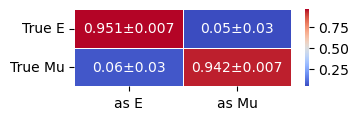

In [42]:
import seaborn as sns
variable_names1 = ['as E', 'as Mu']
variable_names2 = ['True E', 'True Mu']

annot_arr = np.array([['0.951±0.007','0.05±0.03'],
                      ['0.06±0.03','0.942±0.007']], dtype = str)

plt.figure(figsize = (3.5,1))
heatmap = sns.heatmap(confusion, annot=annot_arr, cmap='coolwarm', fmt="s", linewidths=.5, square=False)
heatmap.set_xticklabels(variable_names1, rotation=0)
heatmap.set_yticklabels(variable_names2, rotation=0)
#plt.title("Confusion Matrix")±±±±±
plt.show()